In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
os.environ["WANDB_API_KEY"] = "0"

In [3]:
train=pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test=pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')

In [4]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [7]:
def bert_encode(hypotheses, premises, tokenizer):
    no_lines=len(hypotheses)
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s)for s in np.array(premises)])
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    inputs = {'input_word_ids': input_word_ids.to_tensor(),'input_mask': input_mask,'input_type_ids': input_type_ids}
    return inputs


In [8]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [9]:
max_len = 50
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len), dtype=tf.int32, name="input_type_ids")
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
model = build_model()
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]     

In [11]:
model.fit(train_input, train.label.values, epochs = 10, verbose = 1, batch_size = 16, validation_split = 0.2)

Epoch 1/10
606/606 [==============================] - 340s 561ms/step - loss: 0.9464 - accuracy: 0.5376 - val_loss: 0.8827 - val_accuracy: 0.5809
Epoch 2/10
606/606 [==============================] - 337s 557ms/step - loss: 0.7140 - accuracy: 0.6971 - val_loss: 0.8124 - val_accuracy: 0.6423
Epoch 3/10
606/606 [==============================] - 337s 557ms/step - loss: 0.4852 - accuracy: 0.8071 - val_loss: 0.9491 - val_accuracy: 0.6394
Epoch 4/10
606/606 [==============================] - 337s 557ms/step - loss: 0.2934 - accuracy: 0.8868 - val_loss: 1.0692 - val_accuracy: 0.6547
Epoch 5/10
606/606 [==============================] - 337s 557ms/step - loss: 0.1845 - accuracy: 0.9306 - val_loss: 1.3504 - val_accuracy: 0.6390
Epoch 6/10
606/606 [==============================] - 337s 557ms/step - loss: 0.1184 - accuracy: 0.9576 - val_loss: 1.4655 - val_accuracy: 0.6423
Epoch 7/10
606/606 [==============================] - 337s 557ms/step - loss: 0.0896 - accuracy: 0.9686 - val_loss: 1.7056 -

In [12]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [13]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

In [14]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

prediction
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

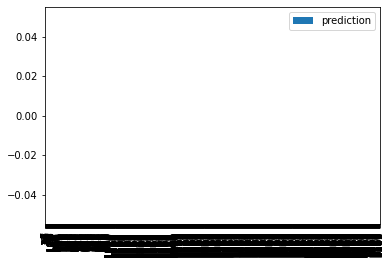

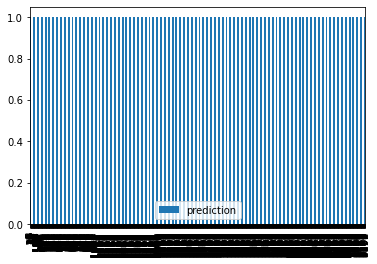

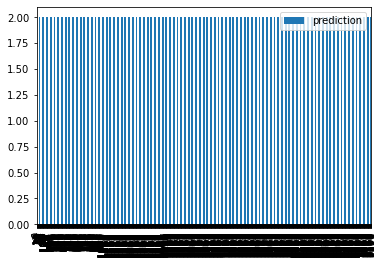

In [15]:
submission.groupby('prediction').plot(kind='bar')

In [16]:
submission.to_csv("submission.csv", index = False)

In [17]:
pip install simpletransformers

     |████████████████████████████████| 206 kB 864 kB/s 
     |████████████████████████████████| 72 kB 862 kB/s 
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 7.5 MB 1.0 MB/s 
     |████████████████████████████████| 4.6 MB 12.9 MB/s 
     |████████████████████████████████| 120 kB 18.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=4f3d049f2d4823edfbcbbbe82c5d2444c55960f290f71ea2d0ae6c4c176ae66f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.45.0
    Uninstalling tqdm-4.45.0:
      Successfully uninstalled tqdm-4.45.0
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformer

In [18]:
from simpletransformers.classification import  ClassificationModel


ImportError: cannot import name 'get_polynomial_decay_schedule_with_warmup' from 'transformers.optimization' (/opt/conda/lib/python3.7/site-packages/transformers/optimization.py)

In [19]:
pip install simpletransformers

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
